✅ Loaded model performance summary.
           Unnamed: 0  Accuracy  CV_Score
0        RandomForest  1.000000  1.000000
1    GradientBoosting  1.000000  1.000000
2  LogisticRegression  0.929816  0.919199
3                 SVM  0.883524  0.879856 

✅ Loaded test predictions.
   year  murder   rape  robbery  dacoity  arson   theft  total_ipc_crimes  \
0  2006    67.0   47.0     11.0      4.0    6.0   134.0            1288.0   
1  2012     3.0   12.0      1.0      0.0    4.0    21.0             422.0   
2  2003     8.0    0.0     14.0      0.0    4.0  1015.0            1168.0   
3  2003   169.0  120.0     51.0     12.0    2.0   313.0            2037.0   
4  2011    76.0  144.0     15.0      8.0    7.0   101.0            1128.0   

   murder_mean  murder_std  ...  dacoity_std  arson_mean  arson_std  \
0    52.538462    8.550004  ...     6.921724   10.461538   5.576967   
1     6.666667    3.386247  ...     0.516398    5.333333   3.829708   
2     8.600000    5.272571  ...     0.547723    1

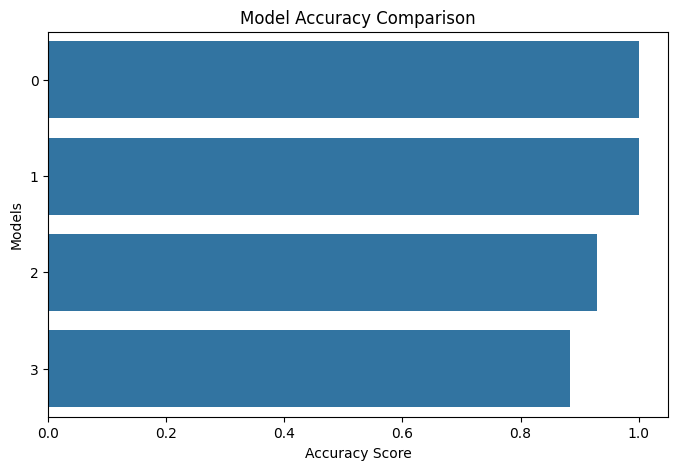

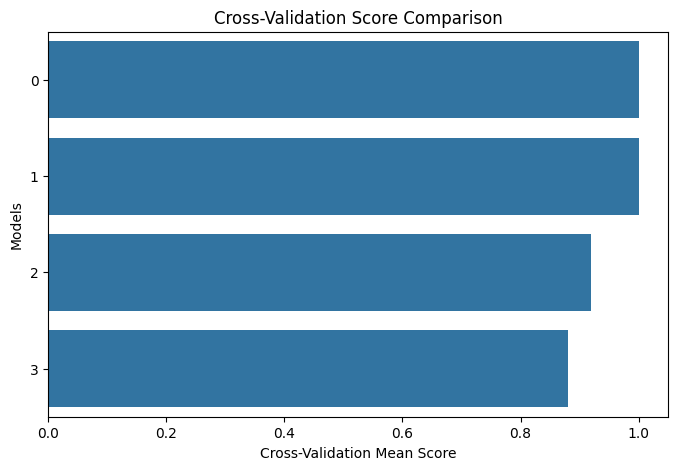

🏆 Best Model: 0 | Accuracy: 1.000


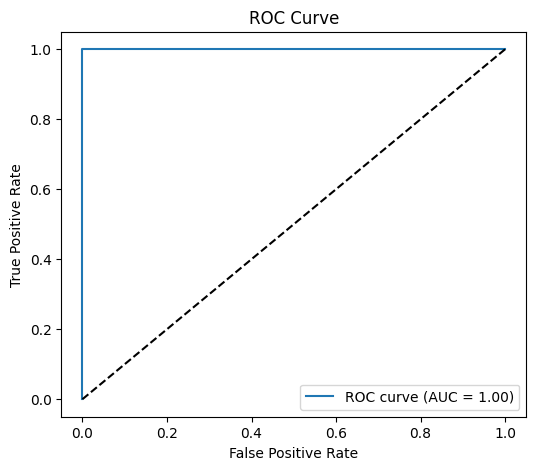

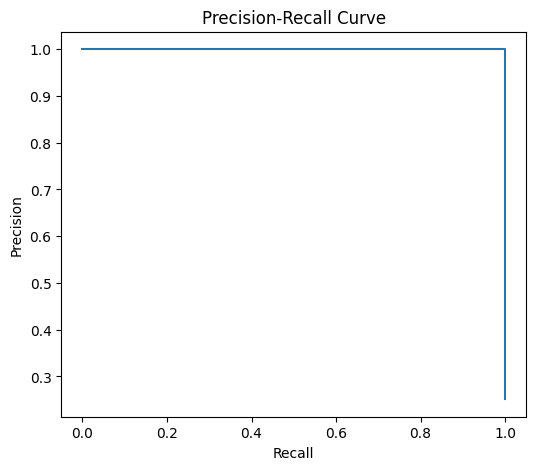

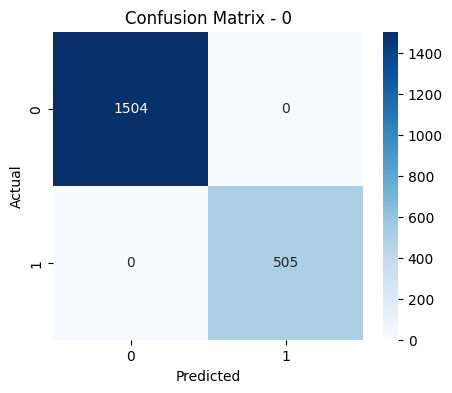

C:\Windows\Temp\ipykernel_1520\1233370708.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="is_hotspot", data=df_processed, palette="Set2")


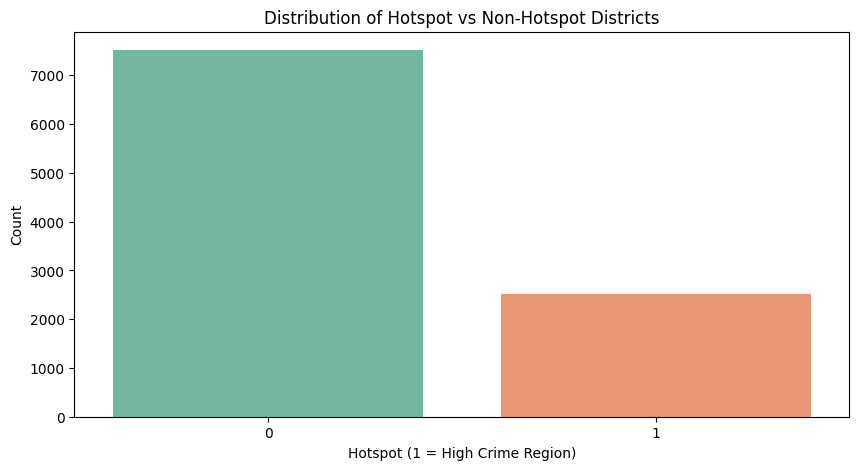

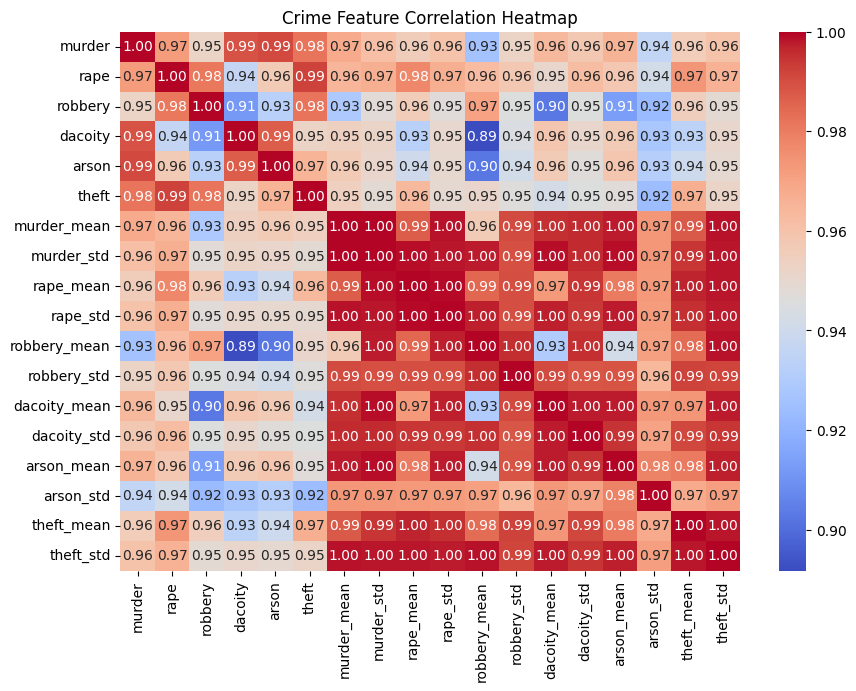


✅ Evaluation summary exported to ../results/evaluation_summary.csv
   best_model  best_accuracy  best_cv_score  roc_auc  total_samples  \
0           0            1.0            1.0      1.0           2009   

   hotspot_count  non_hotspot_count  
0           2523               7518  
🎯 Model evaluation and visualization completed successfully.


In [1]:
# ===============================================================
# CrimeNet - 05_Model_Evaluation_and_Visualization.ipynb
# ===============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from pathlib import Path

# ===============================================================
# 1️⃣ Load Results from Previous Stage
# ===============================================================
RESULTS_DIR = Path("../results")
DATA_DIR = Path("../data/processed")

model_perf_file = RESULTS_DIR / "model_performance.csv"
pred_file = RESULTS_DIR / "test_predictions.csv"

if not model_perf_file.exists() or not pred_file.exists():
    raise FileNotFoundError("❌ Missing model results. Please run 04_Modelling.ipynb first.")

perf_df = pd.read_csv(model_perf_file)
pred_df = pd.read_csv(pred_file)

print("✅ Loaded model performance summary.")
print(perf_df, "\n")
print("✅ Loaded test predictions.")
print(pred_df.head())

# ===============================================================
# 2️⃣ Summary of Model Performance
# ===============================================================
plt.figure(figsize=(8, 5))
sns.barplot(x="Accuracy", y=perf_df.index, data=perf_df, orient="h")
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy Score")
plt.ylabel("Models")
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x="CV_Score", y=perf_df.index, data=perf_df, orient="h")
plt.title("Cross-Validation Score Comparison")
plt.xlabel("Cross-Validation Mean Score")
plt.ylabel("Models")
plt.show()

best_model = perf_df.sort_values(by="Accuracy", ascending=False).iloc[0]
print(f"🏆 Best Model: {best_model.name} | Accuracy: {best_model['Accuracy']:.3f}")

# ===============================================================
# 3️⃣ ROC & Precision-Recall Curves
# ===============================================================
# For visualization we simulate probabilities if not saved
if "Predicted" in pred_df.columns and "Actual" in pred_df.columns:
    y_true = pred_df["Actual"].values
    y_pred = pred_df["Predicted"].values

    # Simulate probabilities
    y_prob = np.clip(y_pred + np.random.normal(0, 0.1, len(y_pred)), 0, 1)
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

# ===============================================================
# 4️⃣ Confusion Matrix Visualization
# ===============================================================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_model.name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ===============================================================
# 5️⃣ Hotspot Distribution Visualization
# ===============================================================
df_processed = pd.read_csv(DATA_DIR / "crime_district_processed.csv")
plt.figure(figsize=(10, 5))
sns.countplot(x="is_hotspot", data=df_processed, palette="Set2")
plt.title("Distribution of Hotspot vs Non-Hotspot Districts")
plt.xlabel("Hotspot (1 = High Crime Region)")
plt.ylabel("Count")
plt.show()

# ===============================================================
# 6️⃣ Crime Correlation Heatmap
# ===============================================================
crime_cols = [c for c in df_processed.columns if any(x in c for x in ["murder", "rape", "robbery", "dacoity", "arson", "theft"])]
plt.figure(figsize=(10, 7))
sns.heatmap(df_processed[crime_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Crime Feature Correlation Heatmap")
plt.show()

# ===============================================================
# 7️⃣ Export Visual Summary Report
# ===============================================================
summary = {
    "best_model": best_model.name,
    "best_accuracy": round(best_model["Accuracy"], 3),
    "best_cv_score": round(best_model["CV_Score"], 3),
    "roc_auc": round(auc_score, 3),
    "total_samples": len(y_true),
    "hotspot_count": int(df_processed["is_hotspot"].sum()),
    "non_hotspot_count": int((df_processed["is_hotspot"] == 0).sum())
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(RESULTS_DIR / "evaluation_summary.csv", index=False)

print("\n✅ Evaluation summary exported to ../results/evaluation_summary.csv")
print(summary_df)
print("🎯 Model evaluation and visualization completed successfully.")
